In [16]:
"""
Created on Wed Mar 30 13:34:55 2022

@author: Seth Sullivan

Here I'm attempting to analytically solve for the win rate given two normal distributions'
"""
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import numba as nb
from numba import njit
from numba import jit
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os 
import data_visualization as dv

In [17]:
#%%
wheel = dv.ColorWheel()
os.chdir('C:\\Users\\Seth Sullivan\\OneDrive - University of Delaware - o365\\Desktop\\Modeling\\Optimal_Decision_Time_Analytical_Figures')
PATH = os.getcwd()

plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False


In [18]:
#%% Update parameters function
def update_params(label_color):
    params = {"ytick.color" : label_color,
              "xtick.color" : label_color,
              "axes.labelcolor" : label_color,
              "axes.edgecolor" : label_color,
              "axes.titlecolor": label_color, 
              'legend.labelcolor': label_color,
              }
    plt.rcParams.update(params)

In [19]:
#%% Heat Map Function

# p1_wins1 rows are the p1_decision times and columns are p2_decision times
# Since P1 wins are the rows, then need to make them columns so it fits with
# having P1 decision times on the x-axis and P2 decision times at y-axis
# Remember that the bottom left is 0,0 bc--> origin = lower
# REMEMBER TO TRANSPOSE ANYTHING NEW***!!*!*!*!*!*!*!*!

def heatmap(p1_wins,p2_wins, decision_means_p1, decision_means_p2, 
            p1_indecision, p2_indecision, SD1,SD2,
            p1_perc_both_decided_wins = None, p2_perc_both_decided_wins=None,simulation = False, probability = True,
            absolute = True, indecisions = False, both_decide = False, abs_minus_both_decided = False, 
            abs_minus_ind=False, abs_plus_both_decided=False, save = False, both_decided_minus_ind = False):
    #Have to transpose to get the axes right
    p1_wins = p1_wins.T
    p2_wins = p2_wins.T
    p1_indecision = p1_indecision.T
    p2_indecision = p2_indecision.T
    if p1_perc_both_decided_wins is not None:
        p1_perc_both_decided_wins = p1_perc_both_decided_wins.T
        p2_perc_both_decided_wins = p2_perc_both_decided_wins.T
    # Calculate percents
    if simulation:
        p1_perc_wins = (p1_wins/NUM_TRIALS)*100
        p2_perc_wins = (p2_wins/NUM_TRIALS)*100
        p1_perc_indecision = (p1_indecision/NUM_TRIALS)*100
        p2_perc_indecision = (p2_indecision/NUM_TRIALS)*100
    if probability:
        p1_perc_wins = (p1_wins)*100
        p2_perc_wins = (p2_wins)*100
        p1_perc_indecision = (p1_indecision)*100
        p2_perc_indecision = (p2_indecision)*100
    # Find average of actual decision times
    # p1_avg_dt = np.zeros((len(decision_means_p1), len(decision_means_p2)))
    # p1_avg_dt_final = np.zeros(len(decision_means_p1))
    # for i in range(len(decision_means_p1)):
    #     for j in range(len(decision_means_p2)):
    #         p1_avg_dt[i,j] = np.mean(p1_decision_time[i,j,:])
    # for i in range(len(decision_means_p1)):
    #     p1_avg_dt_final[i] = np.mean(p1_avg_dt[i,:])       
    # Create array for specific instance -------------------------------------
    if absolute:
        X = np.array([p1_perc_wins,p2_perc_wins])
    if both_decide:
        X = np.array([p1_perc_both_decided_wins, p2_perc_both_decided_wins])
    if indecisions:
        X = np.array([p1_perc_indecision, p2_perc_indecision])
    if abs_minus_both_decided:
        p1_abs_minus_both_decided = p1_perc_wins - p1_perc_both_decided_wins
        p2_abs_minus_both_decided = p2_perc_wins - p2_perc_both_decided_wins
        X = [p1_abs_minus_both_decided,p2_abs_minus_both_decided]
    if abs_minus_ind:
        p1_wins_minus_indecisions = p1_perc_wins - p1_perc_indecision
        p2_wins_minus_indecisions = p1_perc_wins - p1_perc_indecision
        X = np.array([p1_wins_minus_indecisions, p2_wins_minus_indecisions])
    if both_decided_minus_ind:
        X = [p1_perc_both_decided_wins - p1_perc_indecision, p2_perc_both_decided_wins - p2_perc_indecision]
    if abs_plus_both_decided:
        p1_abs_plus_both_decided = p1_perc_wins + p1_perc_both_decided_wins
        p2_abs_plus_both_decided = p2_perc_wins + p2_perc_both_decided_wins
        X = [p1_abs_plus_both_decided,p2_abs_plus_both_decided]
    X_locations = np.arange(len(decision_means_p1))
    Y_locations = np.arange(len(decision_means_p2))
    # Create x-tick labels including normal distribution mean and (decision time mean)
    
    title_label = ['Player 1', 'Player 2']
    if probability:
        title_end = '(Analytical)'
    if simulation:
        title_end = '(Numerical)'
    save_title_label = ['SensoryFeedback_Player1', 'SensoryFeedback_Player2']
    c=0
    weights = {'axis_weight': 550, 'title_weight': 600}
    #print(X[0,:,:])
    for player in X:
        if c ==1:
            break
        # print('SPACE')
        
        # Set labels and titles default to white
        if save:
            update_params('w')
        else:
            update_params('black')
        
        if absolute or both_decide or indecisions:
            vmin = 0
            vmax = 100
        else: 
            vmin = 100
            vmax = -100
        fig, ax = plt.subplots(dpi = 200)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='4%', pad=0.05)
        im = ax.imshow(player, cmap = plt.cm.viridis, origin = 'lower', vmin= vmin, vmax=vmax) #vmin ensures that lowest color is at bottom and vmax ensures brightest color is at top no matter what the max of the data is
        cbar = fig.colorbar(im, cax=cax, orientation='vertical')
        
        ax.set_xticks(X_locations) # Usually need to set the tick locations before the labels 
        ax.set_yticks(Y_locations)
        ax.set_xticklabels(decision_means_p2, fontsize = 'x-small', rotation = 45)
        ax.set_yticklabels(decision_means_p2, fontsize = 'x-small')

        # Select which xtick labels to pick
        n = 3  # Keeps every 4th label
        [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0] 
        [l.set_visible(False) for (i,l) in enumerate(ax.yaxis.get_ticklabels()) if i % n != 0] 

        # # Create second axis for true decision times
        # secax = ax.secondary_xaxis('top', functions = (lambda x: x, lambda x: x))
        # secax.set_xticks(X_locations)
        # secax.set_xticklabels(p1_avg_dt_final.astype(int), size = 'xx-small', rotation = 45)
        # secax.set_xlabel('True Decision Time', fontweight = weights['axis_weight'])
        
        # ax2 = ax.twiny()
        # ax2.set_xticks(X_locations)
        # ax2.set_xticklabels(p1_avg_dt_final.astype(int), fontsize = 'xx-large', rotation = 45)
        # ax2.xaxis.set_ticks_position('top') # set the position of the second x-axis to bottom
        # ax2.xaxis.set_label_position('top') # set the position of the second x-axis to bottom
        # ax2.spines['top'].set_position(('outward', 0))
        # ax2.set_xlabel('True Mean Decision Time')
        
        if absolute:
            ax.set_title(f'{title_label[c]} Absolute Wins '+title_end, fontweight = weights['title_weight'])
            cbar.set_label('Wins (%)', rotation = 270, labelpad = 9.5, fontweight = weights['axis_weight'])
            cbar.set_ticks([20,40,60,80,100])
            cbar.set_ticklabels([20,40,60,80,100])
            cbar.ax.set_ylim(0,100)
            save_name = 'Absolute_Wins'
            txt = 'PLayer 1 absolute wins for each decision time, against each decision time of Player 2.\
                The white crosses indicate the maximum for each row. The decision times are the mean times\
                    used for the normal distribution with SD = 100.'
        if both_decide:
            ax.set_title(f'{title_label[c]} Both Decided Wins', fontweight = weights['title_weight'])
            cbar.set_label('Wins (%)', rotation = 270, labelpad = 9.5, fontweight = weights['axis_weight'])
            cbar.ax.set_ylim(0,100)
            save_name = 'Both_Decided_Wins'
            txt = 'PLayer 1 relative wins for each decision time, against each decision time of Player 2.\
                The white crosses indicate the maximum for each row. The decision times are the mean times\
                    used for the normal distribution with SD = 100.'
        if abs_minus_both_decided:
            ax.set_title(f'{title_label[c]} Absolute - Both Decided Wins', fontweight = weights['title_weight'])
            cbar.set_label('Win Difference (%)', rotation = 270, labelpad = 9.5, fontweight = weights['axis_weight'])
            cbar.ax.set_ylim(-100,100)
      
            save_name = 'Absolute_minus_both_decided'
        if abs_minus_ind:
            ax.set_title(f'{title_label[c]} Absolute Wins - Indecisions', fontweight = weights['title_weight'])
            cbar.set_label('Difference (%)', rotation = 270, labelpad = 9.5, fontweight = weights['axis_weight'])
            cbar.ax.set_ylim(-100,100)
            # cbar.set_ticks([20,40,60,80,100])
            # cbar.set_ticklabels([20,40,60,80,100])
            save_name = 'Absolute_minus_Indecisions'
        if both_decided_minus_ind:
            ax.set_title(f'{title_label[c]} Both Decided Wins - Indecisions', fontweight = weights['title_weight'])
            cbar.set_label('Difference (%)', rotation = 270, labelpad = 9.5, fontweight = weights['axis_weight'])
            cbar.ax.set_ylim(-100,100)
            save_name = 'Both_decided_wins_minus_indecisions'
        if indecisions:
            ax.set_title(f'{title_label[c]} Indecisions', fontweight = weights['title_weight'])
            cbar.set_label('Indecisions (%)', rotation = 270, labelpad = 9.5, fontweight = weights['axis_weight'])
            cbar.ax.set_ylim(0,100)
            save_name = 'Indecisions'
        if abs_plus_both_decided:
            ax.set_title(f'{title_label[c]} Absolute Wins + Both Decide Wins', fontweight = weights['title_weight'])
            cbar.set_label('Wins (%)', rotation = 270, labelpad = 9.5, fontweight = weights['axis_weight'])
            save_name = 'Absolute_wins_plus_both_decided'
        ax.set_xlabel('Player 1 Mean Decision Time', fontweight = weights['axis_weight'])
        ax.set_ylabel('Player 2 Mean Decision Time', fontweight = weights['axis_weight'])
        # USE IF YOU WANT NUMBERS ON EACH BOX
        # for i in range(len(p2_wins)):
        #     for j in range(len(p2_wins)):
               
                # text = ax.text(j, i, f'{player[i,j]:.2f}',
                #             ha="center", va="center", color="w", 
                #             fontweight='medium', size = 'x-small')
        # Place a + on the maximum wins for each row
        for i in range(len(player)):
            if np.all(player == X[1]):
                k = np.argwhere(player[:,i] == np.amax(player[:,i])) #in case of duplicates
                for j in k: 
                    text = ax.text(i, np.argmax(player[:,i]),'+', 
                                   ha="center", va="center", color="w", 
                                   fontweight='medium', size = 'x-small')
            if np.all(player == X[0]):   
                k = np.argwhere(player[i,:] == np.amax(player[i,:])) #in case of duplicates
                for j in k: 
                    text = ax.text(np.argmax(player[i,:]), i, '+',
                                   ha="center", va="center", color="w", 
                                   fontweight='medium', size = 'x-small')
                   
                    
        # Trying to plot something where P1 actually made a decision
        # for i in p1_avg_dt_final:
        #     for j in decision_means_p2:
        #         text = ax.text(i, j,'o', 
        #                            ha="center", va="center", color="r", 
        #                            fontweight='medium', size = 'x-small')
        # print(len(X[0]))
        # x = np.zeros(len(X[0]))
        # x1 = np.zeros(len(X[0]))
        # y = np.zeros(len(X[1]))
        # for i in range(len(p1_wins)):
        #     x[i] = np.argmax(p1_wins[i,:]) #want the location, not the win number
        #     x1[i] = p1_decision_times[int(x[i])] # now place that location into the decision times to get the decision time maximum and then put that into an array to plot
        # ax.scatter(x1,p2_decision_times)    
        if save and c == 0:
            plt.savefig(PATH+f'{save_title_label[c]}_{save_name}_SD1_{SD1}_SD2_{SD2}',
                    dpi=600, bbox_inches = 'tight',transparent=True) 
            print(PATH+f'{save_title_label[c]}_{save_name}_SD1_{SD1}_SD2_{SD2}')
        c=c+1 
    #plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=6)
    plt.tight_layout()
    plt.show()

In [20]:
def plot_optimals(decision_means_p2, optimal_wins, optimal_indecisions, optimal_mean, sig1, sig2):
    plt.figure(dpi=125)
    ax = plt.subplot()
    ax.plot(decision_means_p2,optimal_indecisions,'-o', c = wheel.dark_blue2, label = 'Indecisions')
    ax.plot(decision_means_p2,optimal_wins,'-o', c = wheel.light_blue, label = 'Wins')
    ax.axhline(y=50, c = 'grey', linestyle = '--', alpha = 0.5)
    # ax.axvline(x = 1000, ymin = 0, ymax = optimal_wins[0], color = 'black')
    # ax.axvline(x = 1200, ymin = 0, ymax = optimal_wins[7], color = 'black',zorder = 0)
    ax.set_ylim(-5,100)
    ax.set_yticks(np.arange(0,110,10),np.arange(0,110,10),c = wheel.dark_blue)
    ax.set_xlabel("Player 2 Mean Decision Time")
    ax.set_ylabel(' Percentages (%)')
    ax.spines['left'].set_color(wheel.dark_blue)
    ax.spines['left'].set_linewidth(2)

    ax2 = ax.twinx()
    ax2.plot(decision_means_p2,optimal_mean,'-o', c=wheel.dark_red)
    ax2.set_yticks(np.arange(1000,1600,100))
    ax2.set_yticklabels(np.arange(1000,1600,100),c=wheel.dark_red)
    ax2.set_ylim(1000,1500)
    ax2.spines['right'].set_visible(True)
    ax2.spines['right'].set_color(wheel.dark_red)
    ax2.spines['right'].set_linewidth(2)
    ax2.set_ylabel('Player 1 Mean Decision Time')
    ax2.spines['left'].set_visible(False)
    ax.set_title(f'P1 SD = {sig1}, P2 SD = {sig2}')
    labels = ['Indecisions', 'Wins','Mean Decision Time']
    colors = [wheel.dark_blue2,wheel.light_blue,wheel.dark_red]
    dv.Custom_Legend(ax, labels, colors)
    plt.show()

In [21]:
#%% Calculating analytical probability
def analytical_solution_only_one_feedback(decision_means_p1, decision_means_p2,player_sd,agent_sd):
    

    #decision_means_diff = decision_means_p1 - decision_means_p2

    # Standard deviation 
    sig1,sig2 = player_sd,agent_sd # Sig 1 is player, sig 2 is agent
    var1,var2 = sig1**2,sig2**2
    var_diff = sig1**2 + sig2**2
    sig_diff = np.sqrt(var_diff)
    p1_sensory_evidence_win, p1_random_win, p1_win_from_opp_indecision = np.zeros((len(decision_means_p1),len(decision_means_p2))),np.zeros((len(decision_means_p1),len(decision_means_p2))),np.zeros((len(decision_means_p1),len(decision_means_p2)))
    p2_win100_prob, p2_win50_prob, p2_win_from_opp_indecision = np.zeros((len(decision_means_p1),len(decision_means_p2))),np.zeros((len(decision_means_p1),len(decision_means_p2))),np.zeros((len(decision_means_p1),len(decision_means_p2)))

    p1_indecision, p2_indecision_prob,p1_win_rate,p2_win_rate =np.zeros((len(decision_means_p1),len(decision_means_p2))), np.zeros((len(decision_means_p1),len(decision_means_p2))),np.zeros((len(decision_means_p1),len(decision_means_p2))),np.zeros((len(decision_means_p1),len(decision_means_p2)))
        
    # Expected value multipliers 
    P_100, P_50, P_0 = 1,0.5,0
    delay = 275
    for i in range(len(decision_means_p1)):
        for j in range(len(decision_means_p2)):
            decision_means_diff = decision_means_p1[i] - decision_means_p2[j]
            # Probabilites 
            p1_less_1500 = stats.norm.cdf(1500,decision_means_p1[i],sig1)
            p1_greater_1500 = 1 - p1_less_1500
            p2_less_1500 = stats.norm.cdf(1500,decision_means_p2[j],sig2)
            p2_greater_1500 = 1 - p2_less_1500
            diff_less_200 = stats.norm.cdf(delay,decision_means_diff,sig_diff)
            diff_greater_200 = 1 - diff_less_200
            
            p1_random_win[i,j] = diff_less_200*p1_less_1500*p2_less_1500*P_50
            p1_sensory_evidence_win[i,j] = diff_greater_200*P_100*p1_less_1500*p2_less_1500*P_100
            p1_win_from_opp_indecision[i,j] = p1_less_1500*p2_greater_1500*P_100
            p1_indecision[i,j] = p1_greater_1500
            
            
            p1_win_rate[i,j] = p1_random_win[i,j] + p1_sensory_evidence_win[i,j] + p1_win_from_opp_indecision[i,j]
    return p1_win_rate,p1_indecision
            
            # # Probabilities
            # p1_less_1500 = stats.norm.cdf(1500,decision_means_p1[i],sig1)
            # p1_greater_1500 = 1- p1_less_1500
            # p2_less_1500 = stats.norm.cdf(1500,decision_means_p2[j],sig2)
            # p2_greater_1500 = 1 - p2_less_1500
            # diff_less_200 = stats.norm.cdf(275,decision_means_diff,sig_diff)
            # diff_greater_200 = 1 - diff_less_200
            # diff_less_neg200 = 1 - stats.norm.cdf(-275,decision_means_diff,sig_diff)
            # diff_greater_neg200 = 1 - diff_less_neg200
        
            # # P1 wins by using sensory evidence (aka p1 and p2 must both make it and p1>p2+200)
            # p1_win100_prob[i,j] = (diff_greater_200 * p1_less_1500 * p2_less_1500)*(P_100)
            # # P1 wins by chance
            # p1_win50_prob[i,j] = ((diff_less_200)*p1_less_1500*p2_less_1500)*(P_50) # IF difference is less than reaction delay, then both win with prob 50%
            # p2_win50_prob[i,j] = ((diff_less_200)*p2_less_1500*p1_less_1500)*(P_50)
            # # P1 wins from opponent indecision 
            # p1_win_from_opp_indecision[i,j] = (p1_less_1500 * p2_greater_1500)*P_100
            # p2_win_from_opp_indecision[i,j] = (p2_less_1500 * p1_greater_1500)*P_100
            # # P1 makes an indecision, don't use these in win rate 
            # p1_indecision_prob[i,j] = p1_greater_1500
            # p2_indecision_prob[i,j] = p2_greater_1500
            # p1_win_rate[i,j] = p1_win100_prob[i,j] + p1_win50_prob[i,j] + p1_win_from_opp_indecision[i,j]
            # p2_win_rate[i,j] = p2_win100_prob[i,j] + p2_win50_prob[i,j] + p2_win_from_opp_indecision[i,j]

In [22]:
# Set cosntants and decision means
TRIAL_TIME = 1500
NUM_TRIALS = 100000
#Start and end decision time for player 1
interval = 25
start_time1 = 1000
end_time1 = 1650
total_times1 = int((end_time1 - start_time1) / interval)+1
decision_means_p1 = np.zeros(total_times1)
# Start and end decision time for player 2
start_time = 1000
end_time = 1650
total_times2 = int((end_time - start_time) / interval)+1
decision_means_p2 = np.zeros(total_times2)
# Creating AVERAGE decision time arrays
# To be used in the norm.rvs
for i in range(total_times1):
    decision_means_p1[i] = start_time1
    start_time1 = start_time1 + interval
for i in range(total_times2):
    decision_means_p2[i] = start_time
    start_time = start_time + interval
decision_means_p1 = decision_means_p1.astype(int)
decision_means_p2 = decision_means_p2.astype(int)



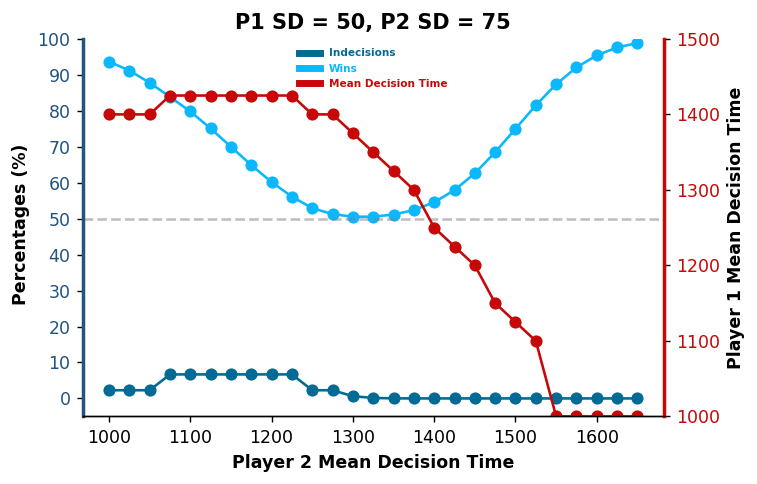

In [23]:
#%% Simulate no feedback 50,50
player1_sigs = np.arange(30,125,25)
player2_sigs = np.arange(25,225,25)
for sig1 in player1_sigs:
    for sig2 in player2_sigs:
        p1_win_rate, p1_indecision_prob = analytical_solution_only_one_feedback(decision_means_p1, decision_means_p2,sig1,sig2)
        optimal_mean = np.zeros(len(decision_means_p1))
        optimal_indecisions = np.zeros(len(decision_means_p1))
        optimal_wins = np.zeros(len(decision_means_p1))
        for k in range(len(decision_means_p2)):
            max_win_index = np.argmax(p1_win_rate[:,k])
            optimal_mean[k] = decision_means_p1[max_win_index]
            optimal_indecisions[k] = p1_indecision_prob[max_win_index,k]
            optimal_wins[k] = p1_win_rate[max_win_index,k]
        plot_optimals(decision_means_p2,optimal_wins*100,optimal_indecisions*100,optimal_mean,sig1,sig2)

In [10]:
#%% Create heatmap
heatmap(p1_win_rate, p2_win_rate, decision_means_p1, decision_means_p2, 
            p1_indecision_prob, p2_indecision_prob,
            sig1, sig2, probability = True,
            absolute=True,both_decide = False, indecisions = False, abs_minus_both_decided=False, abs_plus_both_decided=False,
            abs_minus_ind=False, both_decided_minus_ind = False, save=False)


NameError: name 'p2_win_rate' is not defined